In [32]:
#Import the Libraries
import os
import re
import PIL
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from shutil import copy as copy_file
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image, display
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Flatten
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import load_img, img_to_array


=====	Age: 73	=====


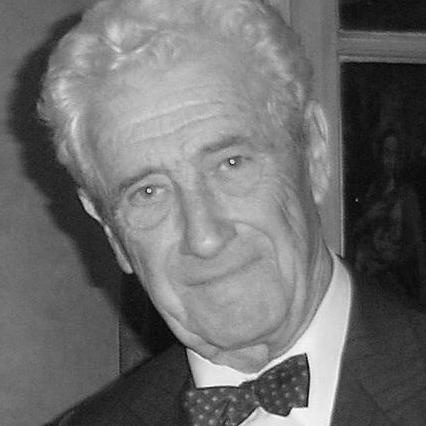


=====	Age: 14	=====


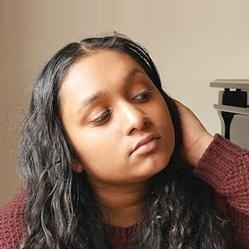


=====	Age: 54	=====


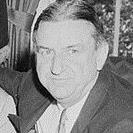


=====	Age: 17	=====


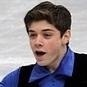


=====	Age: 19	=====


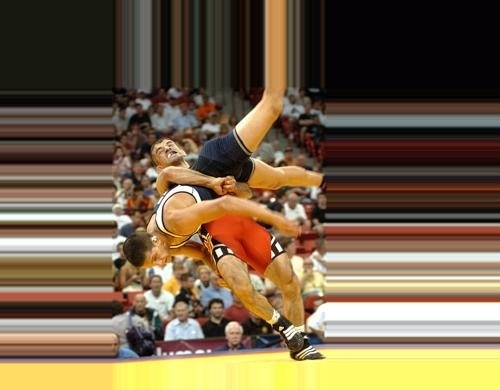

In [10]:
def validate_cleaned_data(imgs_folder_path, num_samples=5):
    # Get a list of cleaned images
    cleaned_images = [file for file in os.listdir(imgs_folder_path) if file.endswith('.jpg')]

    # Randomly select a sample of images
    random_choice = np.random.choice(cleaned_images, min(num_samples, len(cleaned_images)), replace=False)

    # Display the selected images
    for choice in random_choice:
        age = choice.split('_')[0]
        print(f"\n{'='*5}\tAge: {age}\t{'='*5}")
        display(Image(filename=os.path.join(imgs_folder_path, choice), width=200, height=200))

# Example usage
imgs_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team\extracted_images\transformed_images'
num_samples = 5

# Validate cleaned data
validate_cleaned_data(imgs_folder_path, num_samples)


In [12]:
validation_size = 0.5

# Get all image paths
image_paths_all = os.listdir(imgs_folder_path)

# Split into training and validation sets
split_index = int(len(image_paths_all) * validation_size)
image_paths_train = image_paths_all[:split_index]
image_paths_val = image_paths_all[split_index:]

# Print the number of images in each set
print("Training on {} images".format(len(image_paths_train)))
print("Validating on {} images".format(len(image_paths_val)))

Training on 25049 images
Validating on 25050 images


In [27]:
base_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team'
epochs = 2
batch_size = 32
n_models = 3 # Number of YOLOv8 models
validation_size = 0.5

In [38]:

# Preprocessing image before feeding to model
def preprocess(img_paths, imgs_folder_path):
    images = []
    labels = []
    for img_path in img_paths:
        try:
            image = load_img(os.path.join(imgs_folder_path, img_path), target_size=(224, 224)) # Load image
            image = img_to_array(image) # Convert to numpy array
            image = preprocess_input(image) # Preprocess image as required by VGG19 model
            if image.shape != (224, 224, 3):
                continue
            images.append(image)
            labels.append(float(img_path.split('_')[0])) # Extract label from image filename
        except Exception as e:
            print(f"Error processing image {img_path}: {str(e)}")
            continue
    return np.array(images), np.array(labels).reshape(len(labels), 1)

# Generator for batch training
def batch_generator(img_paths, imgs_folder_path, batch_size=16, seed=1):
    np.random.seed(seed)
    np.random.shuffle(img_paths) # Shuffle before use
    i = 0
    while True:
        if i >= len(img_paths): # Resetting generator
            i = 0
        images, labels = preprocess(img_paths[i:i+batch_size], imgs_folder_path)
        i += batch_size
        yield images, labels



In [69]:
imgs_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team\extracted_images\transformed_images'
base_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team'


In [85]:
epochs = 2
batch_size = 32
n_models = 3
validation_size = 0.5

In [76]:
image_paths_all = os.listdir(imgs_folder_path)

In [86]:
print(image_paths_all)

['10_14691279.jpg', '10_17599660.jpg', '10_1944431.jpg', '10_23412525.jpg', '10_23498548.jpg', '10_2408622.jpg', '10_2423138.jpg', '10_24381128.jpg', '10_27577409.jpg', '10_29893257.jpg', '10_33073374.jpg', '10_36633114.jpg', '10_380387.jpg', '10_42758275.jpg', '10_6200536.jpg', '11_1085981.jpg', '11_1125860.jpg', '11_12353105.jpg', '11_1262385.jpg', '11_1342832.jpg', '11_1479589.jpg', '11_15222625.jpg', '11_162279.jpg', '11_1657111.jpg', '11_1783180.jpg', '11_1791278.jpg', '11_23172584.jpg', '11_234657.jpg', '11_2479612.jpg', '11_2532648.jpg', '11_39568371.jpg', '11_40631712.jpg', '11_44205535.jpg', '11_46510488.jpg', '11_4723688.jpg', '11_486936.jpg', '11_603677.jpg', '11_804582.jpg', '11_804594.jpg', '11_8394551.jpg', '11_9595825.jpg', '12_10893515.jpg', '12_10932831.jpg', '12_11754281.jpg', '12_1214425.jpg', '12_13971152.jpg', '12_14767977.jpg', '12_15147462.jpg', '12_16172170.jpg', '12_17066908.jpg', '12_18725383.jpg', '12_20778836.jpg', '12_22354750.jpg', '12_2343573.jpg', '12_24

In [87]:
# Split into training and validation sets
split_index = int(len(image_paths_all) * validation_size)
image_paths_train = image_paths_all[:split_index]
image_paths_val = image_paths_all[split_index:]

In [89]:
# Preprocessing function
def preprocess(img_paths):
    images = []
    labels = []
    for img_path in img_paths:
        image = load_img(os.path.join(imgs_folder_path,img_path), target_size=(224, 224))
        image = img_to_array(image)
        image /= 255.0  # Rescale to [0, 1]
        if image.shape != (224, 224, 3):
            continue
        images.append(image)
        labels.append(float(img_path.split('_')[0]))
    return np.array(images), np.array(labels).reshape(-1, 1)

In [90]:
# Generator function
def batch_generator(img_paths, batch_size=16, seed=1):
    np.random.seed(seed)
    np.random.shuffle(img_paths)
    i = 0
    while True:
        if i >= len(img_paths):
            i = 0
        images, labels = preprocess(img_paths[i:i+batch_size])
        i += batch_size
        yield images, labels

In [91]:
# Function to get the VGG16 model
def get_model(train_last_layers=4):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:-train_last_layers]:
        layer.trainable = False
    top_model = Flatten()(base_model.output)
    top_model = Dense(1, activation='relu')(top_model)
    model = Model(inputs=base_model.inputs, outputs=top_model)
    model.compile(optimizer='Adam', loss='mean_absolute_error')
    return model

In [92]:
# Training loop for multiple models
for model_number in range(n_models):
    model = None
    name = 'Model ' + str(model_number + 1)
    print("\n\t==>", name)
    
    generator_train = batch_generator(image_paths_train, batch_size=batch_size, seed=model_number + 1)
    generator_val = batch_generator(image_paths_val, batch_size=batch_size, seed=model_number + 1)
    
    base_path = os.path.join(base_folder_path, 'model_data', name)
    
    # Create the directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(base_path, 'epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'),
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    callbacks = [checkpoint]
    
    model = get_model(train_last_layers=1)
    model.fit_generator(
        generator_train,
        epochs=epochs,
        steps_per_epoch=len(image_paths_train) // batch_size,
        validation_data=generator_val,
        validation_steps=len(image_paths_val) // batch_size,
        callbacks=callbacks,
        verbose=1
    )


	==> Model 1
Epoch 1/2


C:\Users\vikra\AppData\Local\Temp\ipykernel_15244\4214909844.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


782/782 [==============================] - ETA: 0s - loss: 3.6454WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020C138A40E0> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000020C138A40E0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000020C138A40E0>. Note that functions defined in certain environments, like the interactive Python shell, do not ex

C:\Users\vikra\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


782/782 [==============================] - ETA: 0s - loss: 3.2502
Epoch 2: val_loss improved from 25.61856 to 23.98259, saving model to D:\Assignment\Data Mining & Machine Learning 2\Project\Team\model_data\Model 1\epoch-02_loss-3.2502_val_loss-23.9826.h5
782/782 [==============================] - 3293s 4s/step - loss: 3.2502 - val_loss: 23.9826

	==> Model 2
Epoch 1/2
782/782 [==============================] - ETA: 0s - loss: 3.6916WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000020C13448900> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x0000020C13448900>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do

In [97]:
# Load all models for ensembling
ensemble_models = {}
for model_number in range(n_models):
    name = 'Model ' + str(model_number + 1)
    base_path = os.path.join(base_folder_path, 'model_data', name)
    # Find the last checkpoint for each model
    model_checkpoints = os.listdir(base_path)
    if not model_checkpoints:
        raise ValueError('No checkpoints found for {}'.format(name))
    # Assuming the latest checkpoint is the one with the highest epoch number
    latest_checkpoint = max(model_checkpoints, key=lambda x: int(re.findall(r'\d+', x.split('_')[0])[-1]))
    # Load the model
    model_path = os.path.join(base_path, latest_checkpoint)
    model = load_model(model_path)
    # Append model to the ensemble
    ensemble_models[name] = model


In [98]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

1/1 [==============================] - 0s 93ms/step
 > True Age : 39
 > Predicted Age by Model 1 : 27.5892
 > Predicted Age by Model 2 : 27.3159
 > Predicted Age by Model 3 : 27.8220
 > Predicted Age by Ensembling : 27.5757


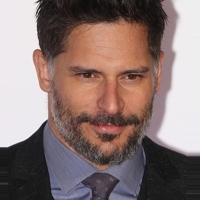

In [213]:
random_choice = list(np.random.choice(image_paths_val,1)) # Choose a random image
test_image, _ = preprocess(random_choice) # Preprocess image
predictions = {}
for model_name,model in ensemble_models.items():
  prediction = model.predict(test_image)
  predictions[model_name] = prediction
print(' > True Age : {}'.format(random_choice[0].split('_')[0]))
ensemble_avg_prediction = 0
for model_name,prediction in predictions.items():
  print(' > Predicted Age by {0} : {1:.4f}'.format(model_name,prediction[0][0]))
  ensemble_avg_prediction = ensemble_avg_prediction + prediction[0][0]
print(' > Predicted Age by Ensembling : {0:.4f}'.format(ensemble_avg_prediction/n_models))
display(Image.open(os.path.join(imgs_folder_path, random_choice[0])).resize((200, 200)))